In [1]:
# comparison of how well a FGN model converted from a classic model performs

# note that to get the exact same results, a tanh(x) need to be added after each fgn layer.

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh


In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [6]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [7]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 2048

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)


Shape: torch.Size([60000, 28, 28])
type: <type 'numpy.ndarray'>
shape: torch.Size([28, 28])
Label: 0
type: <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


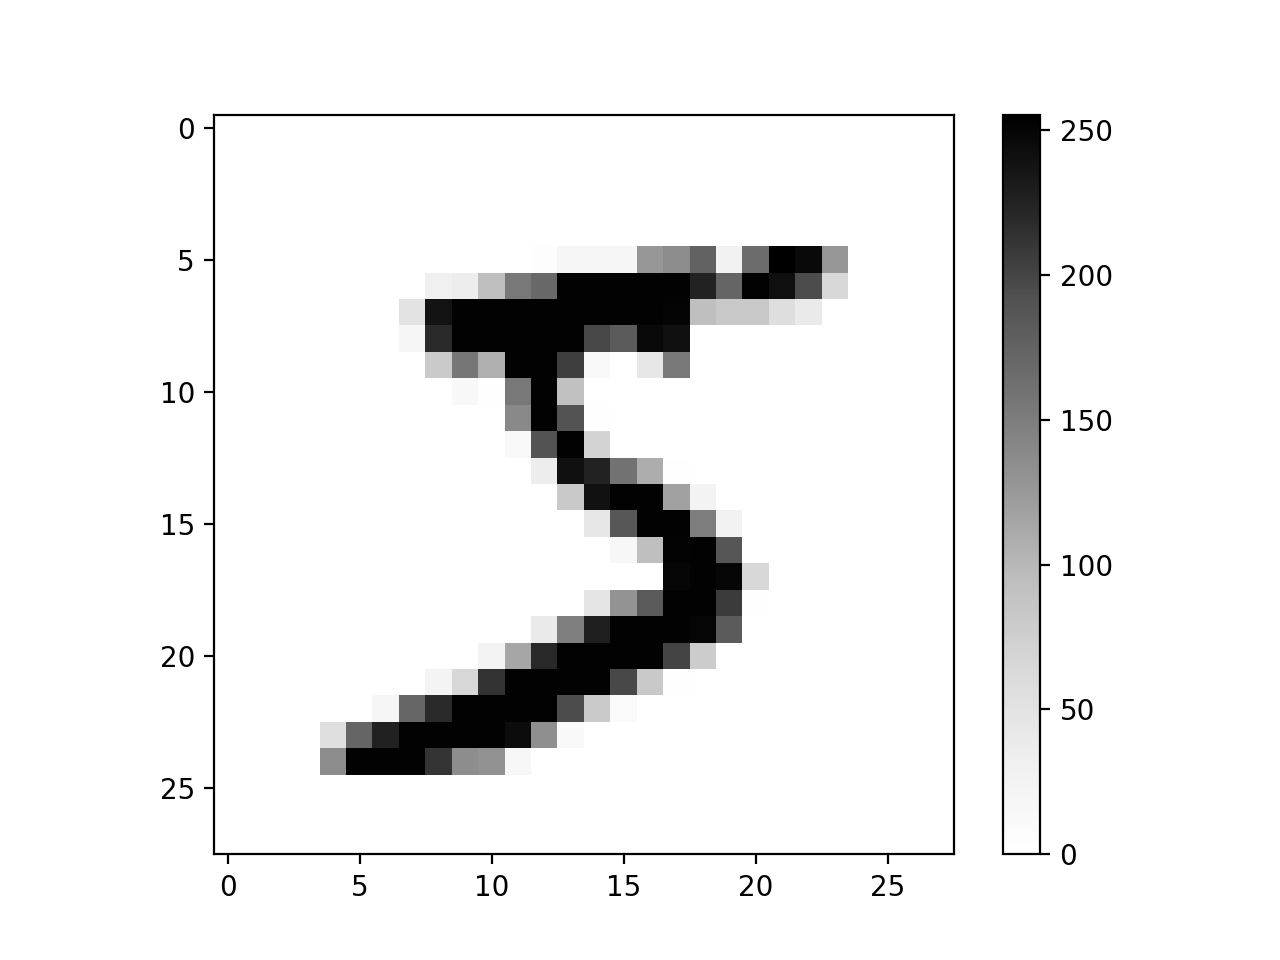

In [8]:
# show an example
print("Shape:", mnist_train_loader.dataset.train_data.shape)
x = mnist_train_loader.dataset.train_data[0]
print("type:", type(x.numpy()))
print("shape:", x.shape)
# print("sample:", x.numpy())

y = mnist_train_loader.dataset.train_labels[1]
print("Label:",y.numpy())
print("type:", type(y))

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()


In [9]:
### PART 1: Train classic feddforward model

In [10]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
print(lmbda_l2)
      
l2_loss = fgnh.l2_loss

def classical_cross_ent_loss(model, output, target):
    cent_loss = F.cross_entropy(output, target.long())
    l2 = l2_loss(model)
    return cent_loss + lmbda_l2*l2

6.66666666667e-06


In [11]:
# Initialize the classic network
hidden_l_nums = [16,16,16]
drop_p= 0.0

In [12]:
classic_model = fgnl.Feedforward_Classic_net(in_feats=28*28, out_feats=10, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

In [13]:
classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()),momentum=0.5)

In [14]:
# train the model
epochs = 1

In [15]:
classic_train_res = fgnh.train(classic_model, device, mnist_train_loader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_test_loader)

Epoch 0 Train set - Average loss: 0.9635, Accuracy: 40549/60000 (68%)
Test set - Average loss: 0.9122, Accuracy: 7108/10000 (71%)


In [16]:
### PART 2: Convert model to FGN

In [17]:
# step 1: Initialize the fgn network
print("hidden layers",hidden_l_nums)
print("drop_p=", drop_p)
fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

hidden layers [16, 16, 16]
drop_p= 0.0


In [18]:
# step 2: convert
fgnl.convert_classic_to_fgn(classic_model, fgn_model)

In [19]:
classic_model_state_dict = classic_model.state_dict()

In [20]:
# test models
classic_test_res = fgnh.test(classic_model, device, mnist_train_loader, 
                             classical_cross_ent_loss, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy)

Test set - Average loss: 0.9201, Accuracy: 42864/60000 (71%)


In [21]:
fgn_test_res = fgnh.test(fgn_model, device, mnist_train_loader, 
                             classical_cross_ent_loss, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy)

Test set - Average loss: 0.9201, Accuracy: 42864/60000 (71%)
